for dicsussion, refer to https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/407972#2272189

In [19]:
# import sys
# sys.path.append('/kaggle/input/ink-00/my_lib')
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')
# sys.path.append('/kaggle/input/einops/einops-master')

In [20]:
import hashlib
import numpy as np
import pandas as pd
from dotdict import dotdict
from time import time


from collections import defaultdict
from glob import glob
import PIL.Image as Image
Image.MAX_IMAGE_PIXELS = 10000000000  # Ignore PIL warnings about large images

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F

from einops import rearrange, reduce, repeat
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.decoders.unet.decoder import UnetDecoder, DecoderBlock
from timm.models.resnet import resnet10t, resnet34d

import numpy as np
import torch
import torch.nn as nn
import torchvision
import datetime
# import cupy
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pytorch_lightning
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
import pytorch_lightning.plugins
from skimage.transform import resize as resize_ski
from pytorch_lightning.strategies.ddp import DDPStrategy
from pytorch_lightning.loggers import WandbLogger
import os


from scipy.ndimage import distance_transform_edt

import glob
import time
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from sklearn.model_selection import KFold
from tqdm import tqdm
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('TkAgg')
%matplotlib inline 
  
print('import ok !!!')

import ok !!!


In [21]:
def time_to_str(time):
    h = time // 3600
    m = (time % 3600) // 60
    s = time % 60
    return f"{h:02f}, {m:02f}, {s:02f}"

In [22]:
class Config(object):
	mode = [
		'train', #
		# 'test', 'skip_fake_test',
	]
	crop_fade  = 56
	crop_size  = 384
	crop_depth = 5
	infer_fragment_z = [28, 37]
	threshold = 0.5
	batch_size = 64
	lr = 1e-4
	batch_size = 64
	num_workers = 8


CFG = Config()
CFG.is_tta = True #True


if 'train' in CFG.mode:
	CFG.stride = CFG.crop_size//2
if 'test' in CFG.mode:
	CFG.stride = CFG.crop_size//2


def cfg_to_text():
    d = Config.__dict__
    text = [f'\t{k} : {v}' for k,v in d.items() if not (k.startswith('__') and k.endswith('__'))]
    d = CFG.__dict__
    text += [f'\t{k} : {v}' for k,v in d.items() if not (k.startswith('__') and k.endswith('__'))]
    return 'CFG\n'+'\n'.join(text)

print(cfg_to_text())

TabError: inconsistent use of tabs and spaces in indentation (2396625376.py, line 13)

In [ ]:
## dataset ##
if 'train' in CFG.mode:
	data_dir = '/home/fummicc1/codes/Kaggle/kaggle-ink-detection/train'
	valid_id =[
	    '1',#'2b',
	]
	train_id = [
		"2", "3"
  	]

if 'test' in CFG.mode: 
	data_dir = '/kaggle/input/vesuvius-challenge-ink-detection/test'
	valid_id = glob(f'{data_dir}/*')
	valid_id = sorted(valid_id)
	valid_id = [f.split('/')[-1] for f in valid_id]
    
	# https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/410985
	a_file = f'{data_dir}/a/mask.png'
	with open(a_file,'rb') as f:
		hash_md5 = hashlib.md5(f.read()).hexdigest()
	is_skip_test = hash_md5 == '0b0fffdc0e88be226673846a143bb3e0'
	print('is_skip_test:',is_skip_test)

#---
print('data_dir', data_dir)
print('valid_id', valid_id)

def do_binarise(m, threshold=0.5):
    m = m-m.min()
    m = m/(m.max()+1e-7)
    m = (m>threshold).astype(np.float32)
    return m

def read_data(fragment_id, z0=CFG.infer_fragment_z[0], z1=CFG.infer_fragment_z[1]):
    volume = []
    start_timer = time()
    for i in range(z0,z1):
        v = np.array(Image.open(f'{data_dir}/{fragment_id}/surface_volume/{i:02d}.tif'), dtype=np.uint16)
        v = (v >> 8).astype(np.uint8)
        #v = (v / 65535.0 * 255).astype(np.uint8)
        volume.append(v)
        print(f'\r @ read_data(): volume{fragment_id}  {time_to_str(time() - start_timer)}', end='', flush=True)
    #print('')
    volume = np.stack(volume, -1)
    height, width, depth = volume.shape
    #print(f'fragment_id={fragment_id} volume: {volume.shape}')

    #---
    mask = cv2.imread(f'{data_dir}/{fragment_id}/mask.png',cv2.IMREAD_GRAYSCALE)
    mask = do_binarise(mask)

    if 'train' in CFG.mode:
        ir    = cv2.imread(f'{data_dir}/{fragment_id}/ir.png',cv2.IMREAD_GRAYSCALE)
        label = cv2.imread(f'{data_dir}/{fragment_id}/inklabels.png',cv2.IMREAD_GRAYSCALE)
        ir    = ir/255
        label = do_binarise(label)

    if 'test' in CFG.mode:
        ir = None
        label = None

    d = dotdict(
        fragment_id = fragment_id,
        volume = volume,
        ir     = ir,
        label  = label,
        mask   = mask,
    )
    return d

def read_data1(fragment_id):
	if fragment_id=='2a':
		y = 9456
		d = read_data('2') 
		d = dotdict(
			fragment_id='2a',
			volume  = d.volume[:y],
			ir      = d.ir[:y],
			label   = d.label[:y],
			mask    = d.mask[:y],
		)
	elif  fragment_id=='2b':
		y = 9456
		d = read_data('2') 
		d = dotdict(
			fragment_id='2b',
			volume  = d.volume[y:],
			ir      = d.ir[y:],
			label   = d.label[y:],
			mask    = d.mask[y:],
		)
	else:
		d = read_data(fragment_id)
	return d

def run_check_data():
    d=read_data1(valid_id[0])#valid_id[0]
    print('')
    print('fragment_id:', d.fragment_id)
    print('volume:', d.volume.shape, d.volume.min(), d.volume.max())
    print('mask  :', d.mask.shape, d.mask.min(), d.mask.max())
    if 'train' in CFG.mode:
        print('ir    :', d.ir.shape, d.ir.min(), d.ir.max())
        print('label :', d.label.shape, d.label.min(), d.label.max())

#run_check_data()
print('data ok !!!')

data_dir /home/fummicc1/codes/Kaggle/kaggle-ink-detection/train
valid_id ['1']
data ok !!!


In [ ]:
def load_mask(split, index):
    img = cv2.imread(f"{data_dir}/{split}/{index}/mask.png", 0) // 255
    return img


def load_labels(split, index):
    img = cv2.imread(f"{data_dir}/{split}/{index}/inklabels.png", 0) // 255
    return img

In [ ]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()

    ctp = preds_t[targets == 1].sum()
    cfp = preds_t[targets == 0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (
        (1 + beta_squared)
        * (c_precision * c_recall)
        / (beta_squared * c_precision + c_recall + smooth)
    )

    return dice

In [ ]:
def extract(location, volume):
    global printed
    x = location[0]
    y = location[1]
    subvolume = volume[x - CFG.crop_size : x + CFG.crop_size, y - CFG.crop_size : y + CFG.crop_size, :].astype(
        np.float32
    )

    return subvolume

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder

from albumentations.core.transforms_interface import ImageOnlyTransform


class SubvolumeDataset(Dataset):
    def __init__(
        self,
        locations,
        volume,
        labels,
        masks,
        buffer,
        is_train: bool,
        return_location: bool = False,
    ):
        self.locations = locations
        self.volume = volume
        self.labels = labels
        self.masks = masks
        self.buffer = buffer
        self.is_train = is_train
        self.return_location = return_location

    def __len__(self):
        return len(self.locations)

    def __getitem__(self, idx):
        label = None
        location = np.array(self.locations[idx])
        y, x = location[0], location[1]

        subvolume = extract(location, self.volume)
        mask = extract(location, self.masks)
        mask = np.stack([mask], axis=-1)

        if self.labels is not None:
            label = self.labels[
                y - self.buffer : y + self.buffer, x - self.buffer : x + self.buffer
            ]
            label = np.stack([label], axis=-1)

        if self.is_train and label is not None:
            transformed = A.Compose(
                [
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.Transpose(p=0.5),
                    A.RandomScale(p=0.5),
                    A.RandomRotate90(p=0.5),
                    A.ShiftScaleRotate(p=0.75),
                    A.GridDropout(p=0.15),
                    A.Resize(height=self.buffer * 2, width=self.buffer * 2),
                ]
            )(image=subvolume, mask=label)
            subvolume = transformed["image"]
            label = transformed["mask"]
            subvolume = np.transpose(subvolume, (2, 0, 1))
            label = np.transpose(label, (2, 0, 1))
            subvolume /= 255.0
            subvolume = (subvolume - 0.45) / 0.225
            return subvolume, label
        else:
            # print("subvolume in val dataset (before aug)", subvolume, file=open("before-val-aug.log", "w"))
            subvolume = np.transpose(subvolume, (2, 0, 1))
            label = np.transpose(label, (2, 0, 1))
            mask = np.transpose(mask, (2, 0, 1))
            subvolume /= 255.0
            subvolume = (subvolume - 0.45) / 0.225
        return subvolume, label, mask

In [ ]:
## model ##
class SmpUnetDecoder(nn.Module):
    def __init__(
        self,
        in_channel,
        skip_channel,
        out_channel,
    ):
        super().__init__()
        self.center = nn.Identity()

        i_channel = [
            in_channel,
        ] + out_channel[:-1]
        s_channel = skip_channel
        o_channel = out_channel
        block = [
            DecoderBlock(i, s, o, use_batchnorm=True, attention_type=None)
            for i, s, o in zip(i_channel, s_channel, o_channel)
        ]
        self.block = nn.ModuleList(block)

    def forward(self, feature, skip):
        d = self.center(feature)
        decode = []
        for i, block in enumerate(self.block):
            s = skip[i]
            d = block(d, s)
            decode.append(d)

        last = d
        return last, decode


class Net(nn.Module):
    def __init__(
        self,
    ):
        super().__init__()
        self.output_type = ["inference", "loss"]

        conv_dim = 64
        encoder1_dim = [
            conv_dim,
            64,
            128,
            256,
            512,
        ]
        decoder1_dim = [
            256,
            128,
            64,
            64,
        ]

        self.encoder1 = resnet34d(pretrained=False, in_chans=CFG.crop_depth)

        self.decoder1 = SmpUnetDecoder(
            in_channel=encoder1_dim[-1],
            skip_channel=encoder1_dim[:-1][::-1],
            out_channel=decoder1_dim,
        )
        # -- pool attention weight
        self.weight1 = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                )
                for dim in encoder1_dim
            ]
        )
        self.logit1 = nn.Conv2d(decoder1_dim[-1], 1, kernel_size=1)

        # --------------------------------
        #
        encoder2_dim = [64, 128, 256, 512]  #
        decoder2_dim = [
            128,
            64,
            32,
        ]
        self.encoder2 = resnet10t(pretrained=False, in_chans=decoder1_dim[-1])

        self.decoder2 = SmpUnetDecoder(
            in_channel=encoder2_dim[-1],
            skip_channel=encoder2_dim[:-1][::-1],
            out_channel=decoder2_dim,
        )
        self.logit2 = nn.Conv2d(decoder2_dim[-1], 1, kernel_size=1)

    def forward(self, batch):
        v = batch["volume"]
        B, C, H, W = v.shape
        vv = [
            v[:, i : i + CFG.crop_depth]
            for i in [
                0,
                2,
                4,
            ]
        ]
        K = len(vv)
        x = torch.cat(vv, 0)
        # x = v

        # ----------------------
        encoder = []
        e = self.encoder1
        x = e.conv1(x)
        x = e.bn1(x)
        x = e.act1(x)
        encoder.append(x)
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        x = e.layer1(x)
        encoder.append(x)
        x = e.layer2(x)
        encoder.append(x)
        x = e.layer3(x)
        encoder.append(x)
        x = e.layer4(x)
        encoder.append(x)
        # print('encoder', [f.shape for f in encoder])

        for i in range(len(encoder)):
            e = encoder[i]
            f = self.weight1[i](e)
            _, c, h, w = e.shape
            f = rearrange(f, "(K B) c h w -> B K c h w", K=K, B=B, h=h, w=w)  #
            e = rearrange(e, "(K B) c h w -> B K c h w", K=K, B=B, h=h, w=w)  #
            w = F.softmax(f, 1)
            e = (w * e).sum(1)
            encoder[i] = e

        feature = encoder[-1]
        skip = encoder[:-1][::-1]
        last, decoder = self.decoder1(feature, skip)
        logit1 = self.logit1(last)

        # ----------------------
        x = last  # .detach()
        # x = F.avg_pool2d(x,kernel_size=2,stride=2)
        encoder = []
        e = self.encoder2
        x = e.layer1(x)
        encoder.append(x)
        x = e.layer2(x)
        encoder.append(x)
        x = e.layer3(x)
        encoder.append(x)
        x = e.layer4(x)
        encoder.append(x)

        feature = encoder[-1]
        skip = encoder[:-1][::-1]
        last, decoder = self.decoder2(feature, skip)
        logit2 = self.logit2(last)
        logit2 = F.interpolate(
            logit2, size=(H, W), mode="bilinear", align_corners=False, antialias=True
        )

        output = {
            "ink": torch.sigmoid(logit2),
        }
        return output


def run_check_net():
    height, width = CFG.crop_size, CFG.crop_size
    depth = CFG.infer_fragment_z[1] - CFG.infer_fragment_z[0]
    batch_size = 3

    batch = {
        "volume": torch.from_numpy(
            np.random.choice(256, (batch_size, depth, height, width))
        )
        .cuda()
        .float(),
    }
    net = Net().cuda()

    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=True):
            output = net(batch)

    # ---
    print("batch")
    for k, v in batch.items():
        print(f"{k:>32} : {v.shape} ")

    print("output")
    for k, v in output.items():
        print(f"{k:>32} : {v.shape} ")


run_check_net()
print("net ok !!!")

batch
                          volume : torch.Size([3, 9, 384, 384]) 
output
                             ink : torch.Size([3, 1, 384, 384]) 
net ok !!!


In [ ]:
###### infer here !!!!
# https://gist.github.com/janpaul123/ca3477c1db6de4346affca37e0e3d5b0
def mask_to_rle(mask):
    m = mask.reshape(-1)
    # m = np.where(mask > threshold, 1, 0).astype(np.uint8)

    s = np.array((m[:-1] == 0) & (m[1:] == 1))
    e = np.array((m[:-1] == 1) & (m[1:] == 0))

    s_index = np.where(s)[0] + 2
    e_index = np.where(e)[0] + 2
    length = e_index - s_index
    rle = " ".join(map(str, sum(zip(s_index, length), ())))
    return rle

In [ ]:
def metric_to_text(ink, label, mask):
    text = []

    p = ink.reshape(-1)
    t = label.reshape(-1)
    pos = np.log(np.clip(p, 1e-7, 1))
    neg = np.log(np.clip(1 - p, 1e-7, 1))
    bce = -(t * pos + (1 - t) * neg).mean()
    text.append(f"bce={bce:0.5f}")

    mask_sum = mask.sum()
    # print(f'{threshold:0.1f}, {precision:0.3f}, {recall:0.3f}, {fpr:0.3f},  {dice:0.3f},  {score:0.3f}')
    text.append("p_sum  th   prec   recall   fpr   dice   score")
    text.append("-----------------------------------------------")
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        p = ink.reshape(-1)
        t = label.reshape(-1)
        p = (p > threshold).astype(np.float32)
        t = (t > 0.5).astype(np.float32)

        tp = p * t
        precision = tp.sum() / (p.sum() + 0.0001)
        recall = tp.sum() / t.sum()

        fp = p * (1 - t)
        fpr = fp.sum() / (1 - t).sum()

        beta = 0.5
        #  0.2*1/recall + 0.8*1/prec
        score = (
            beta * beta / (1 + beta * beta) * 1 / recall
            + 1 / (1 + beta * beta) * 1 / precision
        )
        score = 1 / score

        dice = 2 * tp.sum() / (p.sum() + t.sum())
        p_sum = p.sum() / mask_sum

        # print(fold, threshold, precision, recall, fpr,  score)
        text.append(
            f"{p_sum:0.2f}, {threshold:0.2f}, {precision:0.3f}, {recall:0.3f}, {fpr:0.3f},  {dice:0.3f},  {score:0.3f}"
        )
    text = "\n".join(text)
    return text

In [ ]:
def make_infer_mask():
    s = CFG.crop_size
    f = CFG.crop_fade
    x = np.linspace(-1, 1, s)
    y = np.linspace(-1, 1, s)
    xx, yy = np.meshgrid(x, y)
    d = 1 - np.maximum(np.abs(xx), np.abs(yy))
    d1 = np.clip(d, 0, f / s * 2)
    d1 = d1 / d1.max()
    infer_mask = d1
    return infer_mask

In [ ]:
class Model(pl.LightningModule):
    training_step_outputs = []
    validation_step_outputs = []
    test_step_outputs = [[], []]

    def __init__(self, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()

        self.model = Net()

        self.segmentation_loss_fn = smp.losses.TverskyLoss(
            smp.losses.BINARY_MODE,
            log_loss=False,
            from_logits=False,
            smooth=1e-6,
            alpha=0.5,
            beta=0.6,
        )

    def forward(self, image, stage):
        mask = self.model(image)["ink"]
        return mask

    def shared_step(self, batch, stage):
        if stage == "train":
            subvolumes, labels = batch
        else:
            subvolumes, labels, masks = batch

        image, labels = subvolumes.float(), labels.float()
        assert image.ndim == 4

        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        # print("labels", labels.max(), labels.min())

        assert labels.max() <= 1.0 and labels.min() >= 0

        segmentation_out = self.forward(image, stage)

        loss = self.segmentation_loss_fn(segmentation_out, labels)
        
        score = fbeta_score(segmentation_out, labels, CFG.threshold)

        pred_mask = (segmentation_out > CFG.threshold).float()

        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), labels.long(), mode="binary"
        )

        m = {
            "loss": loss,        
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,    
            "score": score,
        }
        return m

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])
        loss = torch.mean(torch.Tensor([x["loss"] for x in outputs]))
        loss = torch.mean(torch.Tensor([x["loss"] for x in outputs]))
        fbeta_score = torch.mean(torch.Tensor([x["score"] for x in outputs]))
        
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_loss": loss.item(),
            f"{stage}_tp": tp.sum().int().item(),
            f"{stage}_fp": fp.sum().int().item(),
            f"{stage}_fn": fn.sum().int().item(),
            f"{stage}_tn": tn.sum().int().item(),
            f"{stage}_score": fbeta_score.item(),
            f"{stage}_score": fbeta_score.item(),
        }

        self.log_dict(metrics, prog_bar=True, sync_dist=True)

    def training_step(self, batch, batch_idx):
        out = self.shared_step(batch, "train")
        self.training_step_outputs.append(out)
        return out

    def on_train_epoch_end(self):
        out = self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()
        return out

    def validation_step(self, batch, batch_idx):
        out = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(out)
        return out

    def on_validation_epoch_end(self):
        out = self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return out

    def test_step(self, batch, batch_idx):
        pass

    def on_test_epoch_end(self):
        pass

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=CFG.lr)

        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=0.05,
            patience=5,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "monitor": "valid_loss"},
        }

In [ ]:
def train_one(net, d, val_d):

	#get coord
	crop_size  = CFG.crop_size
	stride = CFG.stride
	H,W,D  = d.volume.shape

	##pad #assume H,W >size
	px, py = W % stride, H % stride
	if (px != 0) or (py != 0):
		px = stride - px
		py = stride - py
		pad_volume = np.pad(d.volume, [(0, py), (0, px), (0, 0)], constant_values=0)
  		pad_label = np.pad(d.label, [(0, py), (0, px), (0, 0)], constant_values=0)
	else:
		pad_volume = d.volume

	pH, pW, _  = pad_volume.shape
	x = np.arange(0,pW-crop_size+1,stride)
	y = np.arange(0,pH-crop_size+1,stride)
	x,y = np.meshgrid(x,y)
	xy  = np.stack([x,y],-1).reshape(-1,2)
	print('H,W,pH,pW,len(xy)',H,W,pH,pW,len(xy))
 
 	val_H,val_W,val_D  = d.volume.shape

	##pad #assume H,W >size
	val_px, val_py = val_W % stride, val_H % stride
	if (val_px != 0) or (val_py != 0):
		val_px = stride - val_px
		val_py = stride - val_py
		pad_val_volume = np.pad(val_d.volume, [(0, py), (0, px), (0, 0)], constant_values=0)
  		pad_val_label = np.pad(val_d.label, [(0, py), (0, px), (0, 0)], constant_values=0)
	else:
		pad_val_volume = val_d.volume

	val_pH, val_pW, _  = pad_val_volume.shape
	val_x = np.arange(0,val_pW-crop_size+1,stride)
	val_y = np.arange(0,val_pH-crop_size+1,stride)
	val_x,val_y = np.meshgrid(val_x,val_y)
	val_xy  = np.stack([val_x,val_y],-1).reshape(-1,2)
 
	train_ds = SubvolumeDataset(
		locations=xy,
		volume=pad_volume,
		labels=pad_label,
		BUFFER=crop_size,
		is_train=True,
	)
	val_ds = SubvolumeDataset(
		val_xy,
		pad_val_volume,
		pad_val_label,
		crop_size,
		is_train=False,
	)

	# Define data loaders for training and testing data in this fold
	train_loader = torch.utils.data.DataLoader(
		train_ds,
		batch_size=CFG.batch_size,
		num_workers=CFG.num_workers,
		shuffle=True,
	)
	val_loader = torch.utils.data.DataLoader(
		val_ds,
		batch_size=CFG.batch_size,
		num_workers=CFG.num_workers,
		shuffle=False,
	)

CFG
	mode : ['train']
	crop_fade : 56
	crop_size : 384
	crop_depth : 5
	infer_fragment_z : [28, 37]
	is_tta : True
	stride : 192

 @ read_data(): volume1  0.000000, 0.000000, 1.366579==================================
fragment_id 1
	mask (8181, 6330)
	volume (8181, 6330, 9)
CFG.stride 192
CFG.crop_size 384

H,W,pH,pW,len(xy) 8181 6330 8256 6336 1344
 @infer_one(): 223 / 224 : 0.000000, 0.000000, 38.398234
probability (8181, 6330)


/tmp/ipykernel_4078876/3891300560.py:46: RuntimeWarning: divide by zero encountered in divide
  score = beta * beta / (1 + beta * beta) * 1 / recall + 1 / (1 + beta * beta) * 1 / precision
/tmp/ipykernel_4078876/3891300560.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  score = beta * beta / (1 + beta * beta) * 1 / recall + 1 / (1 + beta * beta) * 1 / precision


bce=0.40077
p_sum  th   prec   recall   fpr   dice   score
-----------------------------------------------
1.00, 0.10, 0.183, 1.000, 0.512,  0.310,  0.219
1.00, 0.20, 0.183, 1.000, 0.512,  0.310,  0.219
1.00, 0.30, 0.183, 1.000, 0.512,  0.310,  0.219
1.00, 0.40, 0.183, 1.000, 0.512,  0.310,  0.219
1.00, 0.50, 0.183, 1.000, 0.512,  0.310,  0.219
0.00, 0.60, 0.000, 0.000, 0.000,  0.000,  0.000
0.00, 0.70, 0.000, 0.000, 0.000,  0.000,  0.000
0.00, 0.80, 0.000, 0.000, 0.000,  0.000,  0.000
0.00, 0.90, 0.000, 0.000, 0.000,  0.000,  0.000



CFG
	mode : ['train']
	crop_fade : 56
	crop_size : 384
	crop_depth : 5
	infer_fragment_z : [28, 37]
	is_tta : True
	stride : 192
  Id Predicted
0  1          
submission.csv ok!!!


'\n \n\n'

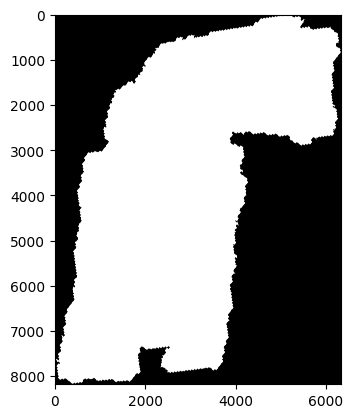

In [ ]:
######################################
if ("skip_fake_test" in CFG.mode) and (is_skip_test):
    submit_df = pd.DataFrame({"Id": valid_id, "Predicted": ["1 2", "1 2"]})
else:
    checkpoint = [
        #'/kaggle/input/ink-01-weight/bug-00007920.model.pth',
        # '/kaggle/input/ink-01-weight/fix-rot-00005904.model.pth',
    ]

    # ----
    net = []
    if len(checkpoint) == 0:
        net = [Net()]
    for i, f in enumerate(checkpoint):
        print(i, f)
        n = Net()
        f = torch.load(f, map_location=lambda storage, loc: storage)
        print(n.load_state_dict(f["state_dict"], strict=True))  # True
        net.append(n)

    # ----
    print(cfg_to_text())
    print("")
    submission = defaultdict(list)
    for t, fragment_id in enumerate(valid_id):
        d = read_data1(fragment_id)

        print("==================================")
        print("fragment_id", d.fragment_id)
        print("\tmask", d.mask.shape)
        print("\tvolume", d.volume.shape)
        print("CFG.stride", CFG.stride)
        print("CFG.crop_size", CFG.crop_size)
        print("")

        probability = infer_one(net, d)
        print("probability", probability.shape)

        probability = d.mask * probability
        predict = (probability > 0.55).astype(np.uint8)

        # ----
        submission["Id"].append(fragment_id)
        submission["Predicted"].append(mask_to_rle(predict))

        # ----
        probability8 = (probability * 255).astype(np.uint8)
        plt.figure(t), plt.imshow(probability8, cmap="gray")
        # plt.waitforbuttonpress()
        if "train" in CFG.mode:
            text = metric_to_text(probability, d.label, d.mask)
            print(text)
        print("")

    print("")
    submit_df = pd.DataFrame.from_dict(submission)

print("")
print(cfg_to_text())
submit_df.to_csv("submission.csv", index=False)
print(submit_df)
print("submission.csv ok!!!")

"""
 

"""